<a href="https://colab.research.google.com/github/bitanb1999/Explain_Depression/blob/main/models/BERT_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Requirements:

In [5]:
!pip install transformers torch lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!apt install git-lfs
!git config --global credential.helper store
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [7]:
import torch
import pandas as pd
torch.cuda.empty_cache()

In [8]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Dataset:

In [9]:
#dataset
df_train = pd.read_csv("/content/train.tsv", sep='\t')
df_test = pd.read_csv("/content/dev_with_labels.tsv", sep='\t')

df_train.set_index('PID',inplace = True)
df_train.reset_index(inplace=True)
df_train.drop("PID",axis=1,inplace=True)

#checking labels
df_train = df_train[(df_train.Label!="nocode")]
df_train = df_train[~(df_train.Label.str.contains("\|"))]

#test set
df_test.set_index('PID',inplace = True)
df_test.reset_index(inplace=True)
df_test.drop("PID",axis=1,inplace=True)

#checking labels
df_test = df_test[(df_test.Label!="nocode")]
df_test = df_test[~(df_test.Label.str.contains("\|"))]
df_train.Label.value_counts()

moderate          6019
not depression    1971
severe             901
Name: Label, dtype: int64

In [10]:
label_dict={}
l=0;
for i in ['not depression','moderate','severe']:
  label_dict[i]=l
  l+=1
label_dict

{'moderate': 1, 'not depression': 0, 'severe': 2}

In [11]:
df_train['Label']=df_train['Label'].apply(lambda x:label_dict[x])
df_train.head()

,Text_data,Label
0,Waiting for my mind to have a breakdown once t...,1
1,My new years resolution : I'm gonna get my ass...,1
2,New year : Somone else Feeling like 2020 will ...,1
3,"My story I guess : Hi, Im from Germany and my ...",1
4,Sat in the dark and cried myself going into th...,1


In [12]:
df_test['Label']=df_test['Label'].apply(lambda x:label_dict[x])
df_test.head()

,Text data,Label
0,"I enjoyed today, and I still am! Tomorrows dep...",1
1,I sorta tried to kill myself : I had a total b...,1
2,Best suicide method? : I like it quick and eas...,1
3,a story : I remember the time I'd get on my 3D...,1
4,The world only cares about beautiful people : ...,1


In [13]:
#obtaining sentence score for each sentence
import nltk
nltk.download('vader_lexicon')
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent = SentimentIntensityAnalyzer()
polarity = [round(sent.polarity_scores(i)['compound'], 2) for i in df_train['Text_data']]
df_train['sentiment_score'] = polarity
df_train.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,Text_data,Label,sentiment_score
0,Waiting for my mind to have a breakdown once t...,1,-0.93
1,My new years resolution : I'm gonna get my ass...,1,-0.62
2,New year : Somone else Feeling like 2020 will ...,1,-0.13
3,"My story I guess : Hi, Im from Germany and my ...",1,0.98
4,Sat in the dark and cried myself going into th...,1,0.36


In [14]:
df_test.rename(columns={'Text data':'Text_data'},inplace=True)

In [15]:
polarity = [round(sent.polarity_scores(i)['compound'], 2) for i in df_test['Text_data']]
df_test['sentiment_score'] = polarity
df_test.head()

,Text_data,Label,sentiment_score
0,"I enjoyed today, and I still am! Tomorrows dep...",1,0.99
1,I sorta tried to kill myself : I had a total b...,1,-0.58
2,Best suicide method? : I like it quick and eas...,1,0.73
3,a story : I remember the time I'd get on my 3D...,1,0.94
4,The world only cares about beautiful people : ...,1,1.00


In [31]:
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
token_lens = []
for txt in df_train.Text_data:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


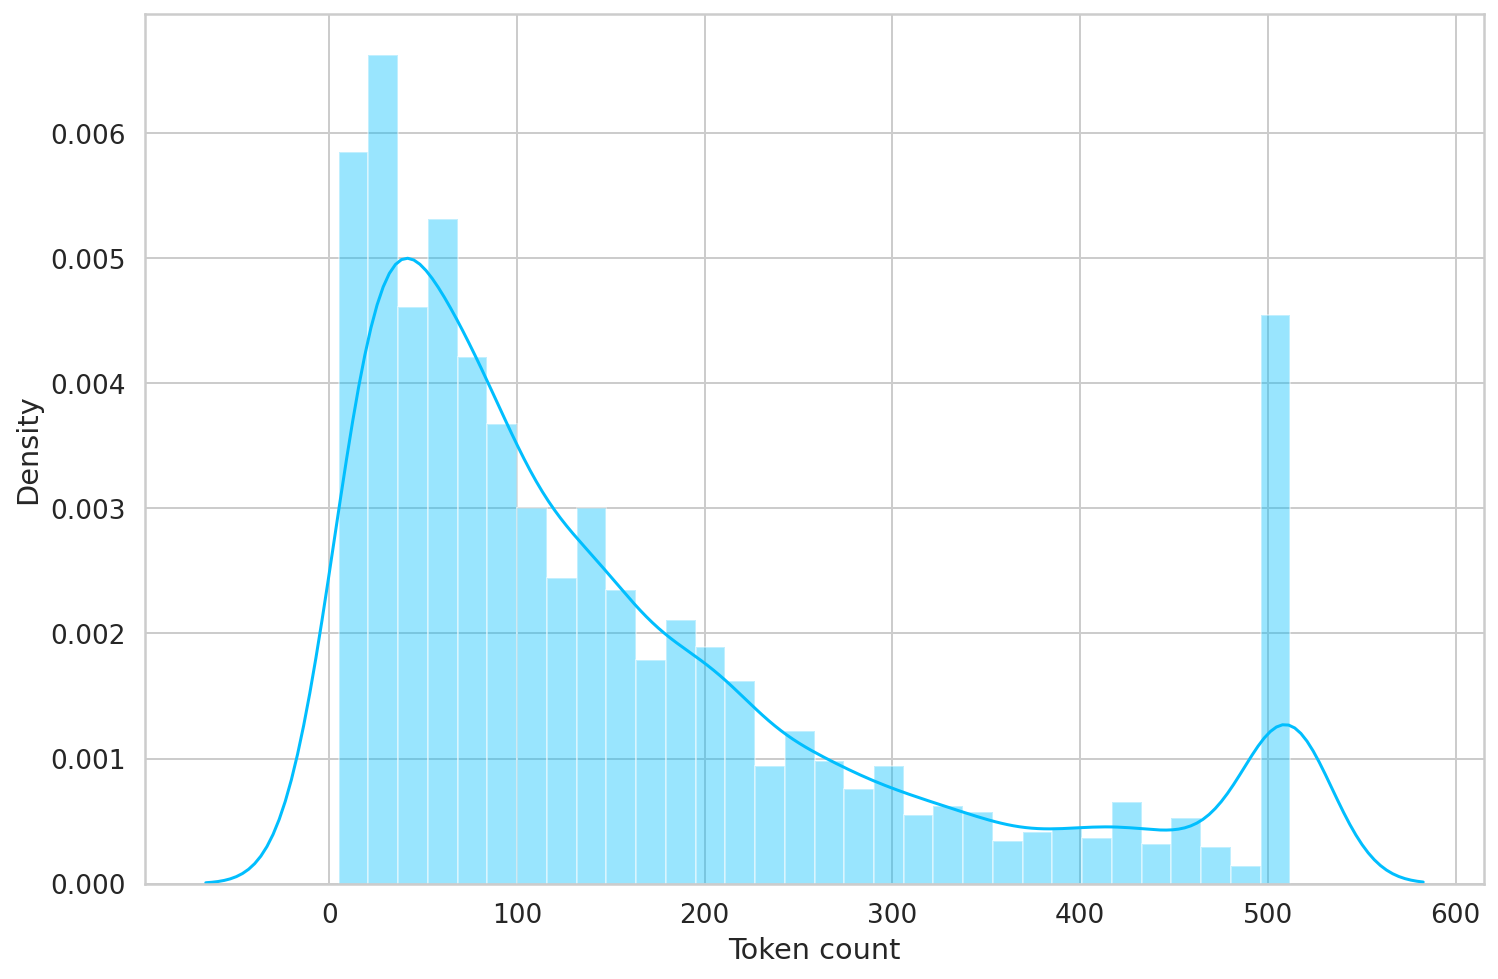

In [18]:
sns.distplot(token_lens)
#plt.xlim([0, 256]);
plt.xlabel('Token count');

In [33]:
MAX_LEN = 512
class GPSentimentDataset(Dataset):
  def __init__(self, texts, targets, tokenizer, max_len):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.texts)
  def __getitem__(self, item):
    text = str(self.texts[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [34]:
df_train, df_val = train_test_split(
  df_train[['Text_data','Label']],
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_test=df_test[['Text_data','Label']]

In [35]:
df_test.shape,df_train.shape

((4496, 2), (7200, 2))

In [36]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPSentimentDataset(
    texts=df.Text_data.to_numpy(),
    targets=df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [37]:
BATCH_SIZE = 8
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [38]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [39]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8])


### Model:

In [40]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,return_dict=False
    )
    output = self.drop(pooled_output,)
    return self.out(output)

In [41]:
model = SentimentClassifier(3)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 512])
torch.Size([8, 512])


In [43]:
EPOCHS = 4
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [44]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [45]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

### Train and Evaluate:

In [46]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  
  print(f'Val_loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.5508760590271817 accuracy 0.8109722222222222


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val_loss 0.43542332103992304 accuracy 0.8714107365792759

Epoch 2/4
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.26347092862228033 accuracy 0.9220833333333334


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val_loss 0.4521448808251926 accuracy 0.8938826466916354

Epoch 3/4
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.15479162170480576 accuracy 0.9613888888888888


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val_loss 0.4772430120870508 accuracy 0.9038701622971286

Epoch 4/4
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.09174514057321681 accuracy 0.9784722222222222


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val_loss 0.47967126489084416 accuracy 0.9051186017478152

CPU times: user 47min 47s, sys: 21.2 s, total: 48min 8s
Wall time: 48min 6s


In [47]:
hist={}
hist['train_acc']=[y.cpu() for y in history['train_acc']]
hist['val_acc']=[y.cpu() for y in history['val_acc']]

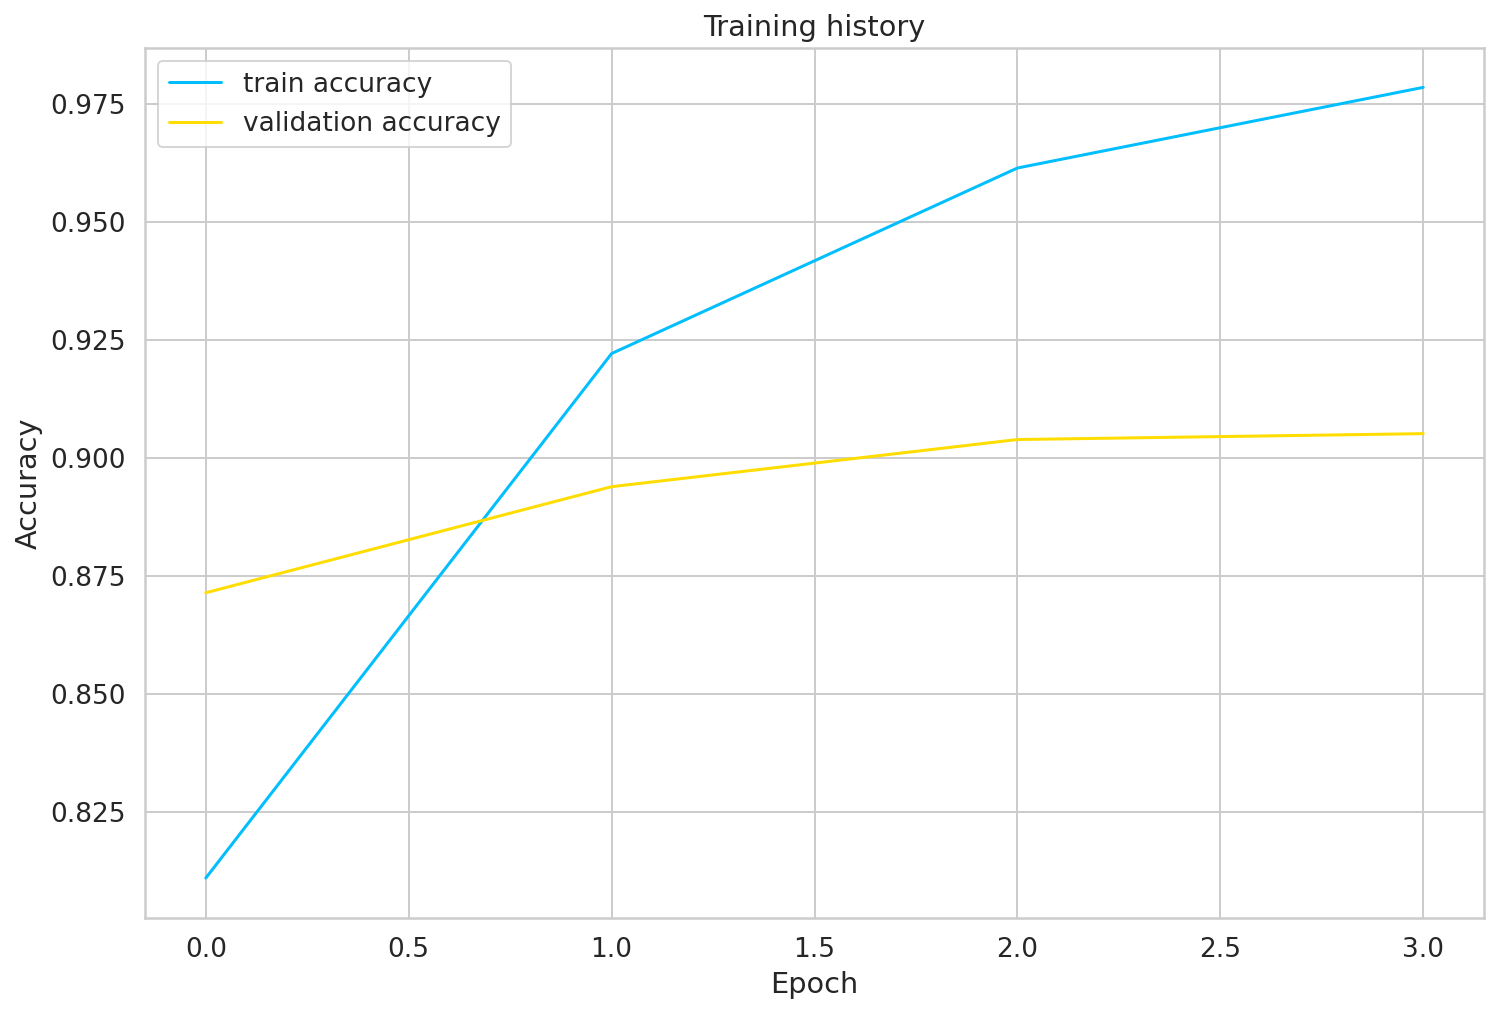

In [48]:
plt.plot(hist['train_acc'], label='train accuracy')
plt.plot(hist['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

In [49]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

0.5533807829181494

In [50]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [51]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

In [52]:
print(classification_report(y_test, y_pred, target_names=['not depression','moderate','severe']))

                precision    recall  f1-score   support

not depression       0.57      0.48      0.53      1830
      moderate       0.60      0.61      0.60      2306
        severe       0.33      0.56      0.41       360

      accuracy                           0.55      4496
     macro avg       0.50      0.55      0.51      4496
  weighted avg       0.57      0.55      0.56      4496



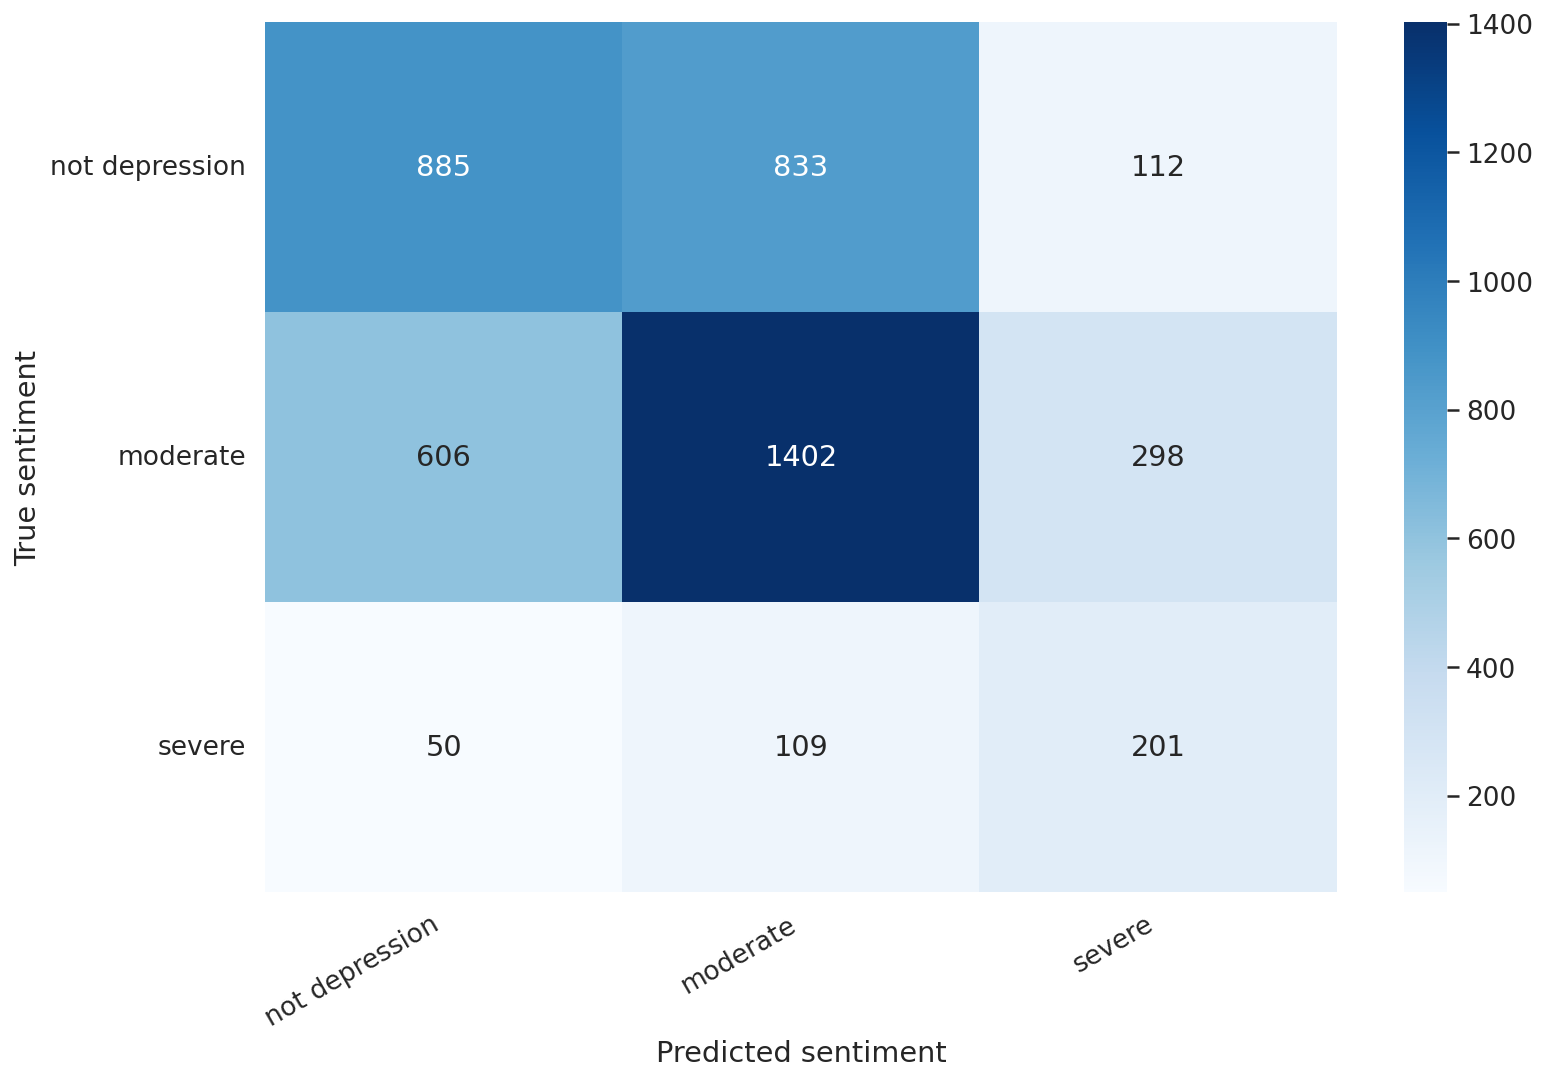

In [53]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['not depression','moderate','severe'], columns=['not depression','moderate','severe'])
show_confusion_matrix(df_cm)

In [54]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  train_data_loader
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

In [55]:
print(classification_report(y_test, y_pred, target_names=['not depression','moderate','severe']))

                precision    recall  f1-score   support

not depression       0.97      0.98      0.98      1617
      moderate       0.99      0.99      0.99      4860
        severe       0.97      0.97      0.97       723

      accuracy                           0.99      7200
     macro avg       0.98      0.98      0.98      7200
  weighted avg       0.99      0.99      0.99      7200



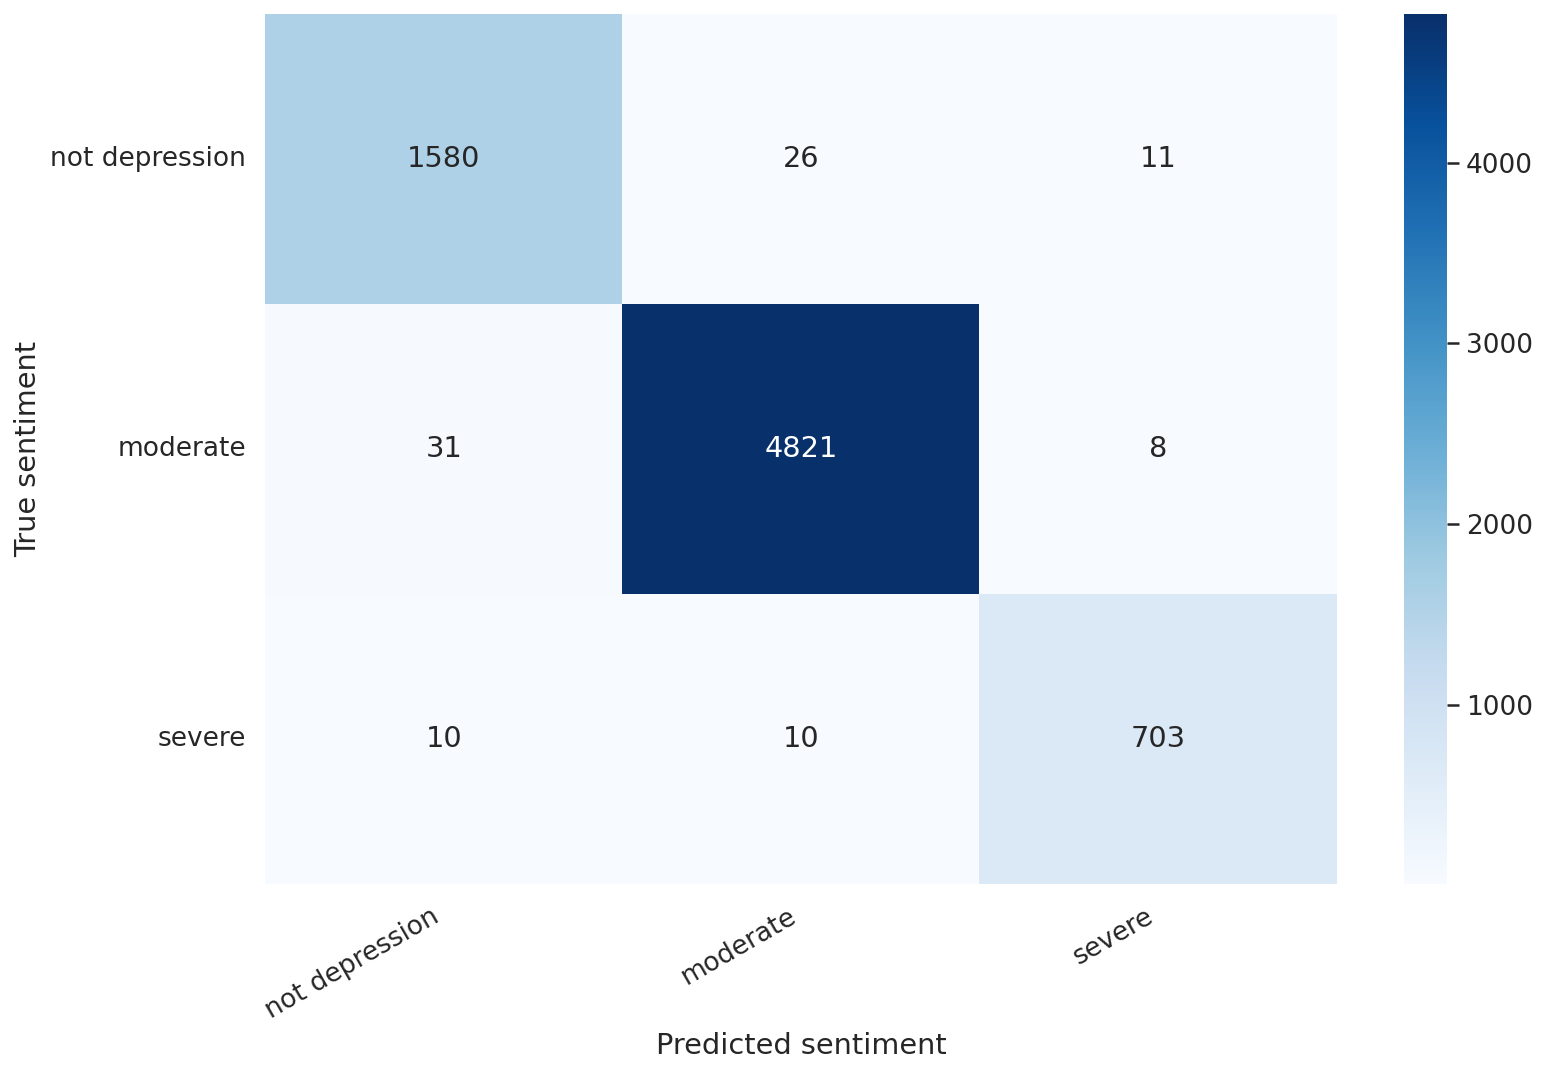

In [56]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['not depression','moderate','severe'], columns=['not depression','moderate','severe'])
show_confusion_matrix(df_cm)

### Model Storage:

In [57]:
!huggingface-cli repo create Bert_finetuned

git version 2.17.1
Error: unknown flag: --version

Sorry, no usage text found for "git-lfs"

You are about to create BitanBiswas/Bert_finetuned
Proceed? [Y/n] Y

Your repo now lives at:
  https://huggingface.co/BitanBiswas/Bert_finetuned

You can clone it locally with the command below, and commit/push as usual.

  git clone https://huggingface.co/BitanBiswas/Bert_finetuned



In [58]:
!git clone https://huggingface.co/BitanBiswas/Bert_finetuned

Cloning into 'Bert_finetuned'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [59]:
!git lfs install
!git config --global user.email "bitanbiswas99@gmail.com"
# Tip: using the same email than for your huggingface.co account will link your commits to your profile
!git config --global user.name "BitanBiswas"

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.


In [60]:
model.bert.save_pretrained("/content/Bert_finetuned")
tokenizer.save_pretrained("/content/Bert_finetuned")

('/content/Bert_finetuned/tokenizer_config.json',
 '/content/Bert_finetuned/special_tokens_map.json',
 '/content/Bert_finetuned/vocab.txt',
 '/content/Bert_finetuned/added_tokens.json')

In [62]:
%cd Bert_finetuned
!git add --all
!git status

/content/Bert_finetuned
On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	new file:   config.json
	new file:   pytorch_model.bin
	new file:   special_tokens_map.json
	new file:   tokenizer_config.json
	new file:   vocab.txt



In [63]:
!git commit -m "First version of the deepD model and tokenizer."

[main e786e30] First version of the deepD model and tokenizer.
 5 files changed, 30574 insertions(+)
 create mode 100644 config.json
 create mode 100644 pytorch_model.bin
 create mode 100644 special_tokens_map.json
 create mode 100644 tokenizer_config.json
 create mode 100644 vocab.txt


In [64]:
!git push

Git LFS: (1 of 1 files) 417.71 MB / 417.71 MB
Counting objects: 7, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 109.29 KiB | 5.46 MiB/s, done.
Total 7 (delta 0), reused 0 (delta 0)
To https://huggingface.co/BitanBiswas/Bert_finetuned
   9d49291..e786e30  main -> main


In [65]:
!git add .
!git commit -m "Initial commit"
!git push

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Everything up-to-date


### Explainability:

In [66]:
from transformers import BertConfig,BertTokenizer,  BertModel
model_type = 'BitanBiswas/Bert_finetuned'
config = BertConfig.from_pretrained(model_type)
config.output_attentions=True
model = BertModel.from_pretrained(model_type,config = config).to('cpu')
tokenizer = BertTokenizer.from_pretrained(model_type)

In [67]:
text1 = 'I am depressed I feel so terribly worthless around everyone  '
text2 = 'I speak to'
tok1 = tokenizer.tokenize(text1)
tok2 = tokenizer.tokenize(text2)

In [68]:
#visualisation of a depression class text
p_pos = len(tok1) # position for token
tok = tok1+tok2
tok,p_pos, tok[p_pos]

(['i',
  'am',
  'depressed',
  'i',
  'feel',
  'so',
  'terribly',
  'worthless',
  'around',
  'everyone',
  'i',
  'speak',
  'to'],
 10,
 'i')

In [69]:
ids = torch.tensor(tokenizer.convert_tokens_to_ids(tok)).unsqueeze(0).to('cpu')
with torch.no_grad():
    output = model(ids)
attentions = torch.cat(output[2]).to('cpu')
attentions.shape

torch.Size([12, 12, 13, 13])

In [70]:
attentions = attentions.permute(2,1,0,3)
print(attentions.shape)

torch.Size([13, 12, 12, 13])


In [71]:
layers = len(attentions[0][0])
heads = len(attentions[0])
seqlen = len(attentions)
layers,heads,seqlen


(12, 12, 13)

In [72]:
attentions_pos = attentions[p_pos]
attentions_pos.shape

torch.Size([12, 12, 13])

Attention weights for token i


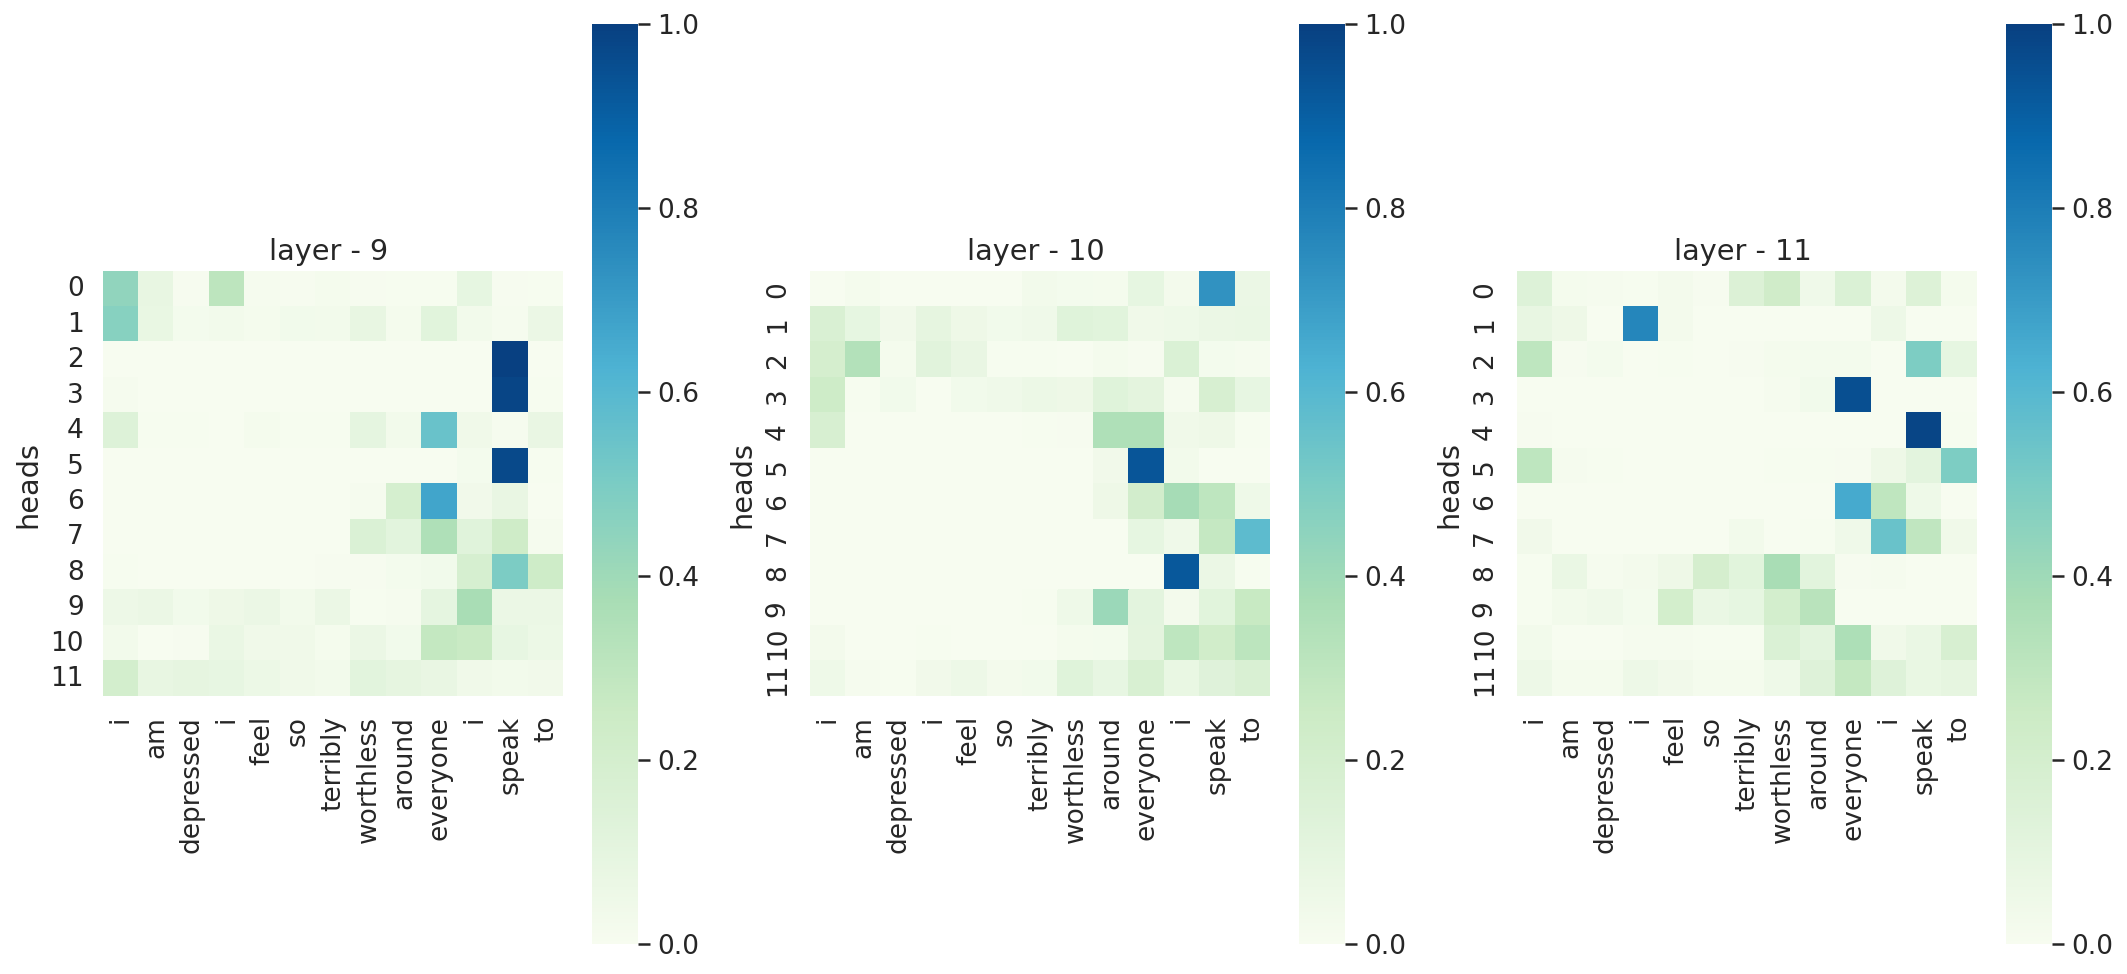

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots( 1,3, figsize = (15,7))
axes = axes.flat
sum=np.zeros((12,13))
aveg=np.zeros((12,13))
maxi=np.zeros((12,13))
print (f'Attention weights for token {tok[p_pos]}')
for i,att in enumerate(attentions_pos[9:]):
  sum=[[sum[k][j] + att[k][j]  for j in range(len(sum[0]))] for k in range(len(sum))]
  if i==0:
    aveg=sum
  aveg=[[(aveg[k][j]+att[k][j])/2  for j in range(len(sum[0]))] for k in range(len(sum))]
  maxi=[[max(maxi[k][j],att[k][j]) for j in range(len(sum[0]))] for k in range(len(sum))]
  im = axes[i].imshow(att, cmap='gray')
  sns.heatmap(att,vmin = 0, vmax = 1,ax = axes[i], xticklabels = tok,cmap="GnBu")
  axes[i].set_title(f'layer - {i+9} ' )
  axes[i].set_ylabel('heads')
  fig.tight_layout()
#plt.suptitle('Attention for i in a depressed class text')
plt.savefig(f'base_attention_depression_')

Attention weights for token i


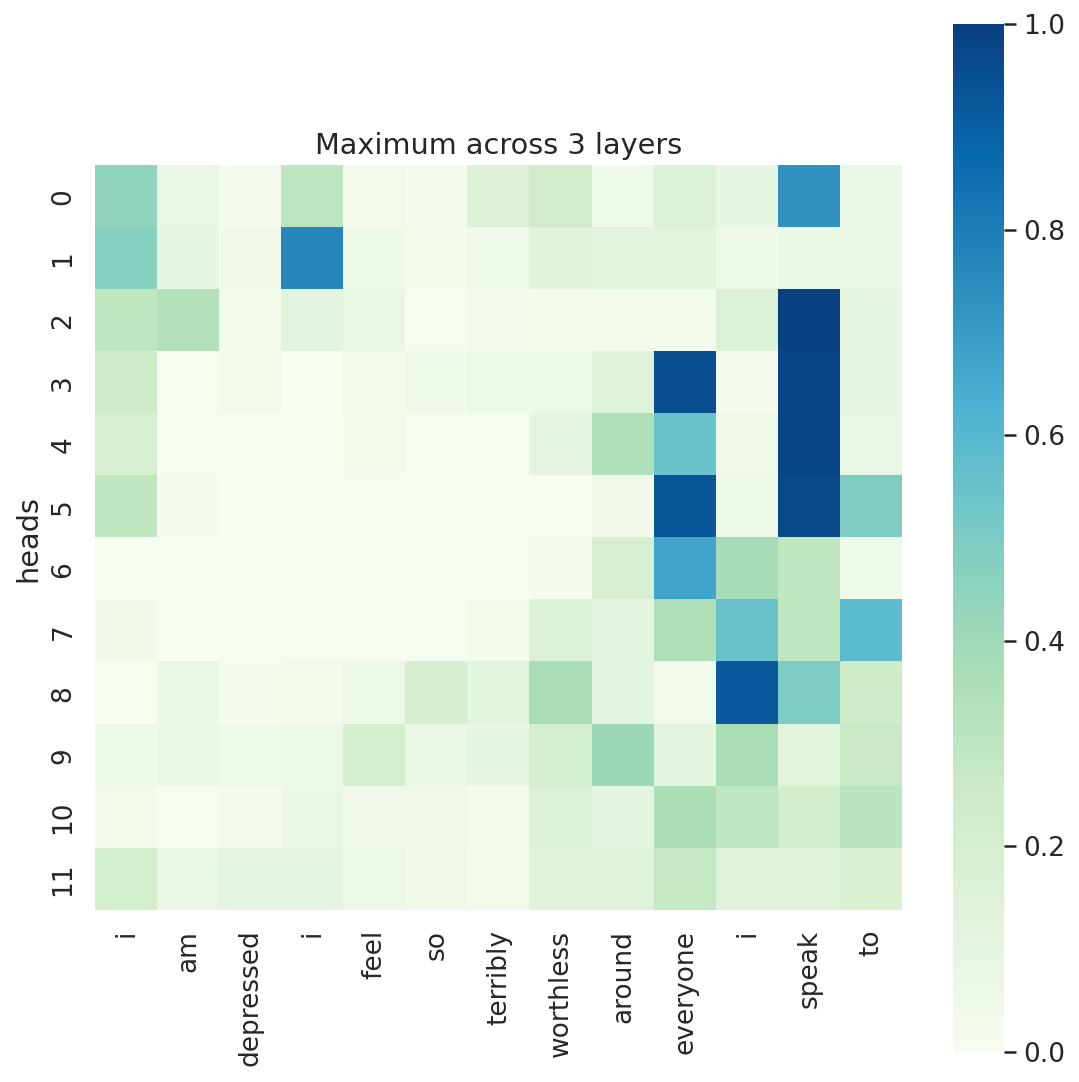

In [75]:
fig, axes = plt.subplots( 1,1, figsize = (8,8))
print (f'Attention weights for token {tok[p_pos]}')
im = axes.imshow(att, cmap='gray')
sns.heatmap(maxi,vmin = 0, vmax = 1,ax = axes, xticklabels = tok,cmap="GnBu")
axes.set_title('Maximum across 3 layers' )
axes.set_ylabel('heads')
fig.tight_layout()
plt.savefig(f'base_attention_depression_average')

In [76]:
text1 = 'Well i am alone and  i am just '
text2 = 'wondering how everyone is doing '
tok1 = tokenizer.tokenize(text1)
tok2 = tokenizer.tokenize(text2)

In [77]:
#visualisation of no depression class
p_pos = len(tok1) # position for token
tok = tok1+tok2
ids = torch.tensor(tokenizer.convert_tokens_to_ids(tok)).unsqueeze(0).to('cpu')
with torch.no_grad():
    output = model(ids)
attentions = torch.cat(output[2]).to('cpu')
attentions.shape

torch.Size([12, 12, 13, 13])

Attention weights for token wondering


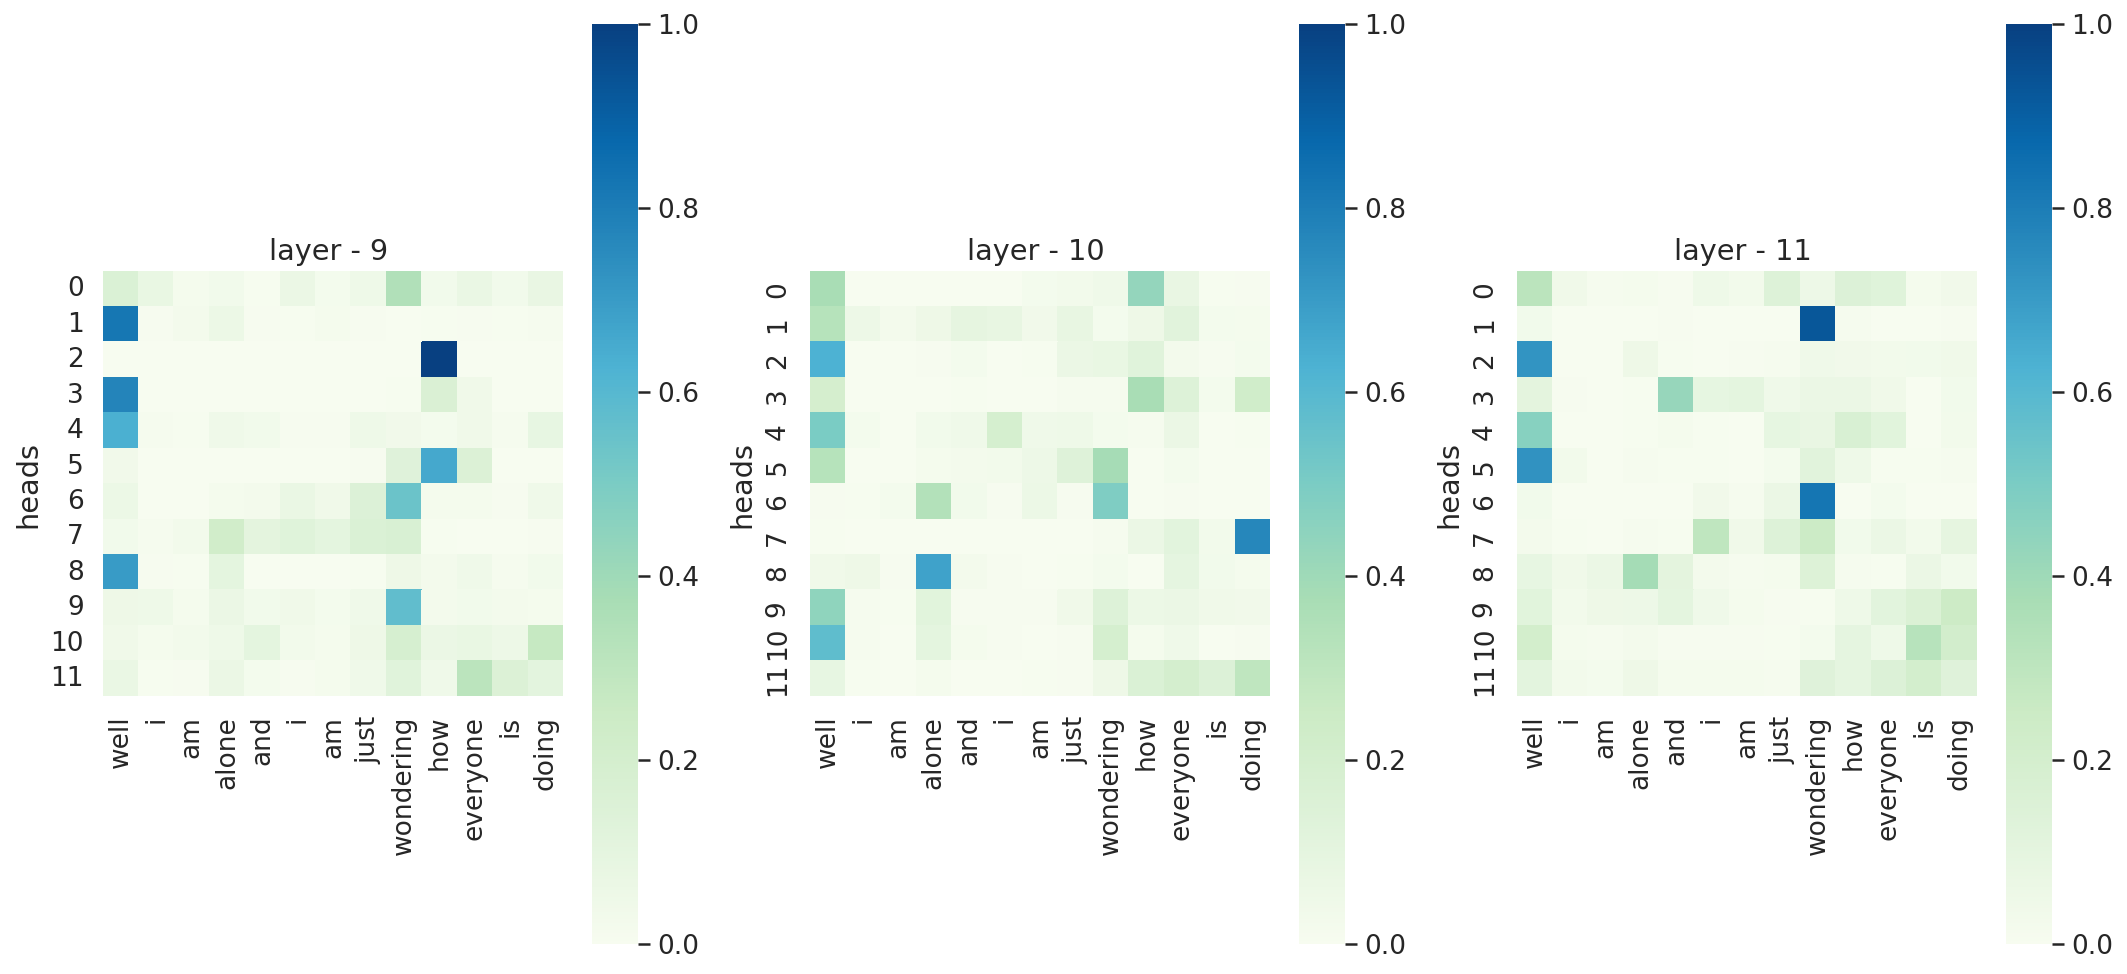

In [78]:
attentions = attentions.permute(2,1,0,3)
attentions_pos = attentions[p_pos]
fig, axes = plt.subplots( 1,3, figsize = (15,7))
axes = axes.flat
sum=np.zeros((12,13))
aveg=np.zeros((12,13))
maxi=np.zeros((12,13))
print (f'Attention weights for token {tok[p_pos]}')
for i,att in enumerate(attentions_pos[9:]):
  sum=[[sum[k][j] + att[k][j]  for j in range(len(sum[0]))] for k in range(len(sum))]
  if i==0:
    aveg=sum
  aveg=[[(aveg[k][j]+att[k][j])/2  for j in range(len(sum[0]))] for k in range(len(sum))]
  maxi=[[max(maxi[k][j],att[k][j]) for j in range(len(sum[0]))] for k in range(len(sum))]
  im = axes[i].imshow(att, cmap='gray')
  sns.heatmap(att,vmin = 0, vmax = 1,ax = axes[i], xticklabels = tok,cmap="GnBu")
  axes[i].set_title(f'layer - {i+9} ' )
  axes[i].set_ylabel('heads')
  fig.tight_layout()
#plt.suptitle('Attention for i in a non-depressed class text')
plt.savefig(f'base_attention_nondepression')

Attention weights for token wondering


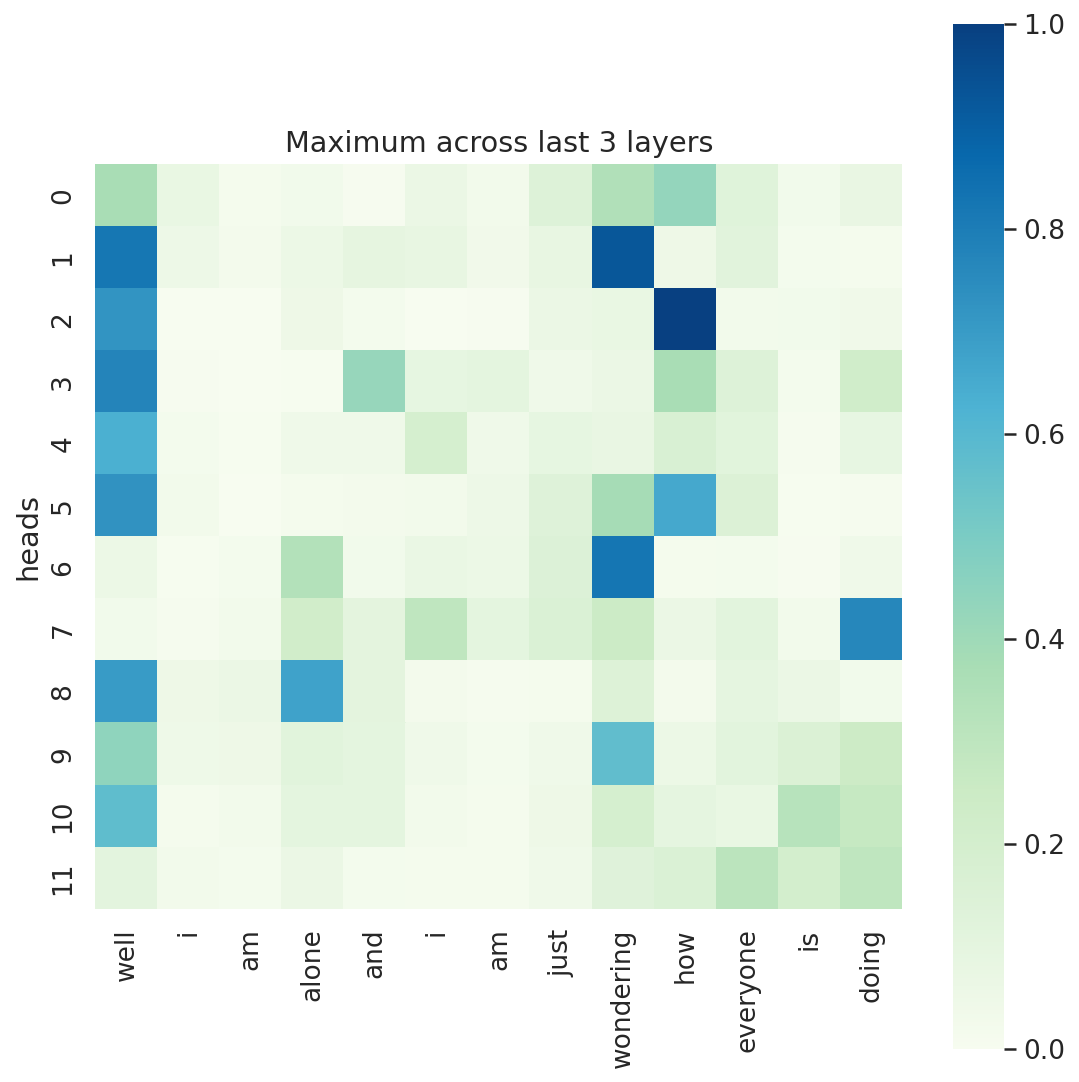

In [79]:
fig, axes = plt.subplots( 1,1, figsize = (8,8))
print (f'Attention weights for token {tok[p_pos]}')
im = axes.imshow(att, cmap='gray')
sns.heatmap(maxi,vmin = 0, vmax = 1,ax = axes, xticklabels = tok,cmap="GnBu")
axes.set_title('Maximum across last 3 layers' )
axes.set_ylabel('heads')
fig.tight_layout()
plt.savefig(f'attention-nondepression_average_singlesample')

In [80]:
def get_attention(sen,tok_pos):
  tok=tokenizer.tokenize(sen)
  ids = torch.tensor(tokenizer.convert_tokens_to_ids(tok)).unsqueeze(0).to('cpu')
  with torch.no_grad():
    output = model(ids)
  attentions = torch.cat(output[2]).to('cpu')
  attentions = attentions.permute(2,1,0,3)
  attentions_pos = attentions[tok_pos]
  sum=np.zeros((attentions_pos[0].shape))
  aveg=sum
  maxi=sum
  for i,att in enumerate(attentions_pos[9:]):
      sum=[[sum[k][j] + att[k][j]  for j in range(len(sum[0]))] for k in range(len(sum))]
      if i==0:
        aveg=sum
      aveg=[[(aveg[k][j]+att[k][j])/2  for j in range(len(sum[0]))] for k in range(len(sum))]
      maxi=[[max(maxi[k][j],att[k][j]) for j in range(len(sum[0]))] for k in range(len(sum))]
  m=np.average(np.array([y[tok_pos] for y in maxi]))
  return m

In [81]:
def countX(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count

In [82]:
def sort_index(lst, rev=True):
    index = range(len(lst))
    s = sorted(index, reverse=rev, key=lambda i: lst[i])
    return s


In [83]:
def cal_df(df):
  tokenCount={}
  tokenAtten={}
  token={}
  di=[]
  sen=[]
  for i in range(len(df['Text_data'])):
    if (len(df.iloc[i]['Text_data'])>=512):
      tok=tokenizer.tokenize(df.iloc[i]['Text_data'][:512])
    else:
      tok=tokenizer.tokenize(df.iloc[i]['Text_data'])
    ids = torch.tensor(tokenizer.convert_tokens_to_ids(tok)).unsqueeze(0).to('cpu')
    with torch.no_grad():
      output = model(ids)
    attentions = torch.cat(output[2]).to('cpu')
    attentions = attentions.permute(2,1,0,3)
    attentions_pos = attentions[0]
    m=np.max(attentions_pos[11].numpy(),axis=0)
    sen.append(tok[np.argmax(m)])
    token={'token':tok,'count':len(tok),'attentionscore':m}
    di.append(token)
    tokenCount[i]=[tok[i] for i in sort_index(m)[:3]]
    tokenAtten[i]=[m[i] for i in sort_index(m)[:3]]
  return tokenCount,tokenAtten,di

In [84]:
import pandas as pd
df=pd.read_csv('/content/train.tsv',sep='\t')[:500]
tokenCount,tokenAtten,di=cal_df(df)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


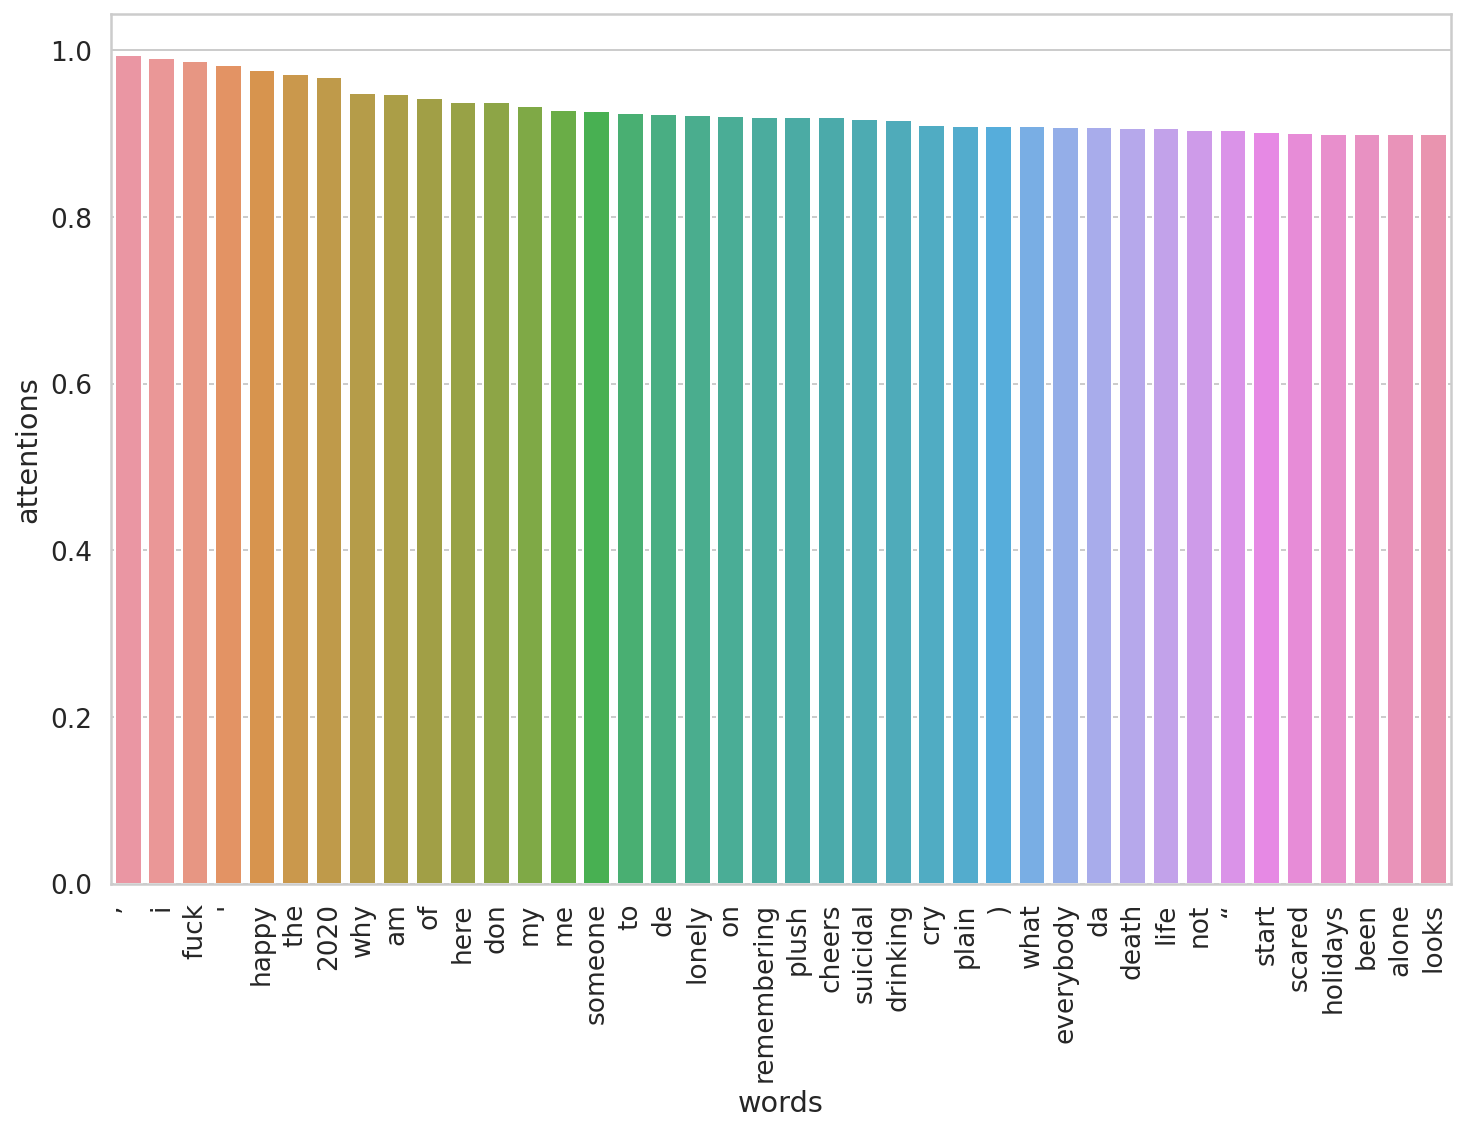

In [85]:
get_attention('I am done with life. I want to die',0)
tk=pd.DataFrame(columns=['words','attention'])
tk['words']=pd.Series([tokenCount[i][0] for i in range(500)])
tk['attention']=pd.Series([tokenAtten[i][0] for i in range(500)])
tk=tk.sort_values(by='attention')
arr=tk['words'].unique()[:80]
p=[]
for i in range(len(arr)):
  p.append([arr[i],max(tk[tk.words==arr[i]]['attention'])])
  d=pd.DataFrame(p,columns=['words','attentions']).sort_values(by='attentions',ascending=False)
sns.barplot(d['words'][:40],d['attentions'][:40])
plt.xticks(rotation=90)
plt.savefig('highattentiontowords')